In [3]:
import pandas as pd

cols = (
    ["engine_id", "cycle"] +
    [f"op_setting_{i}" for i in range(1, 4)] +
    [f"sensor_{i}" for i in range(1, 22)]
)

df = pd.read_csv(
    "../data/raw/train_FD001.txt",
    sep=r"\s+",
    header=None,
    names=cols
)

df.head()


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
def add_rul(df):
    max_cycles = df.groupby("engine_id")["cycle"].max()
    df["RUL"] = df.apply(lambda row: max_cycles[row["engine_id"]] - row["cycle"],axis=1)
    return df


In [5]:
df = add_rul(df)



## x&y in plotting
x - represents the cycles.
y - represents the sensor value.
as x cycles change, the corresponding sensor_values also changes.

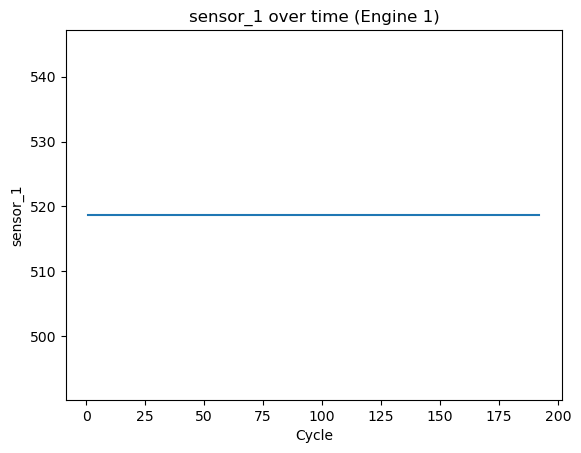

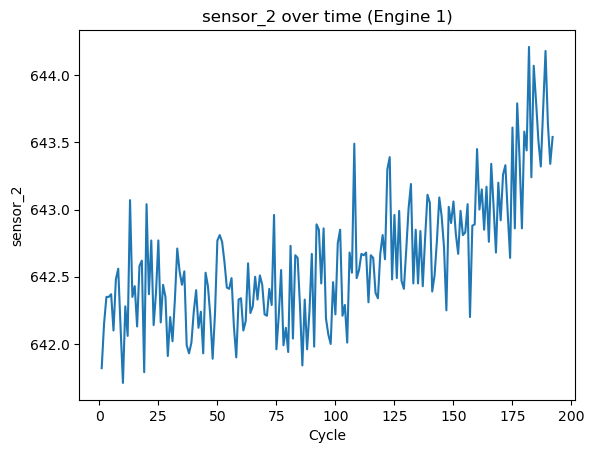

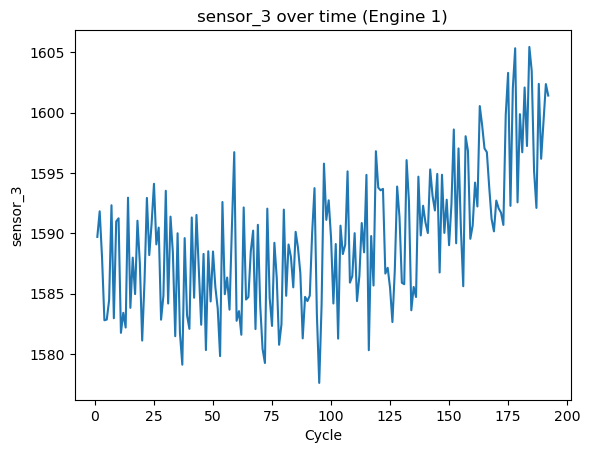

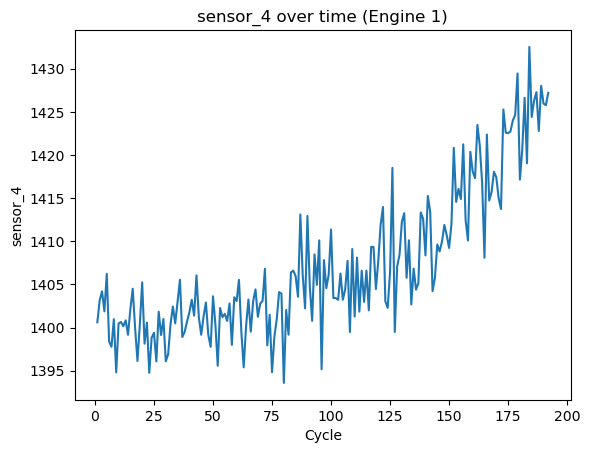

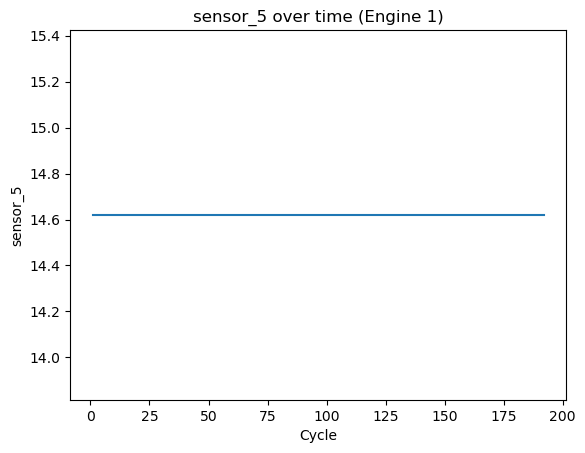

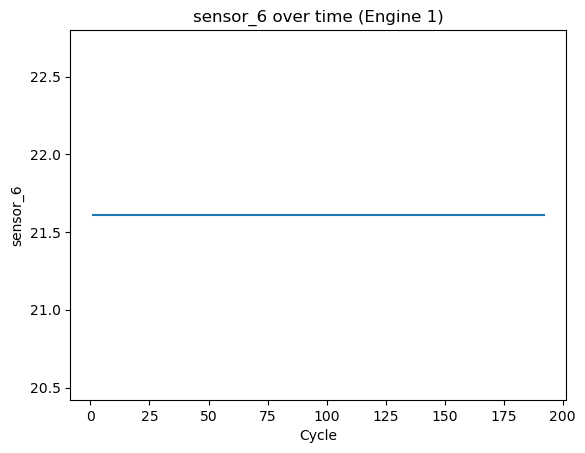

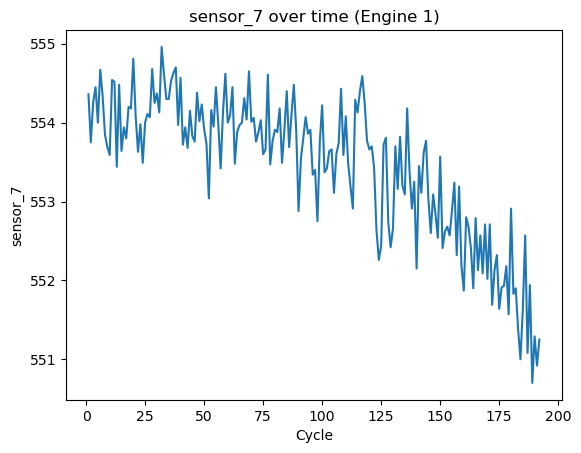

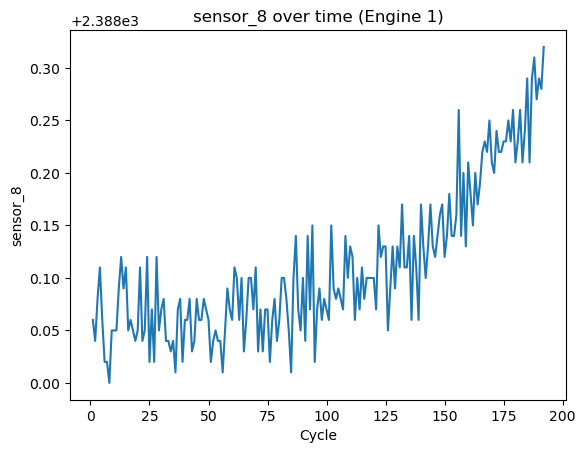

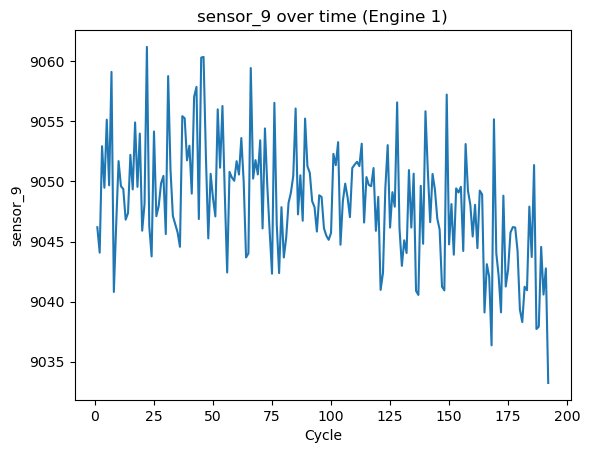

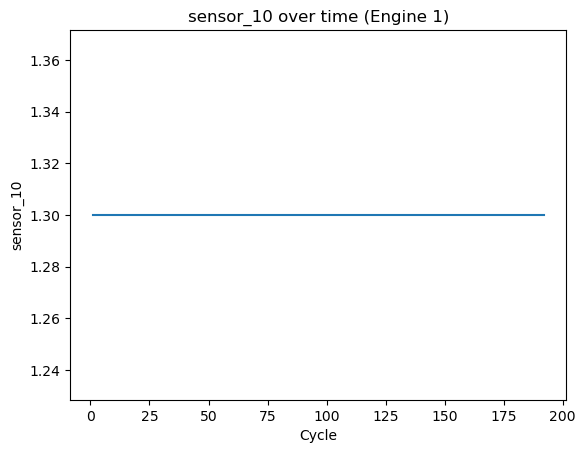

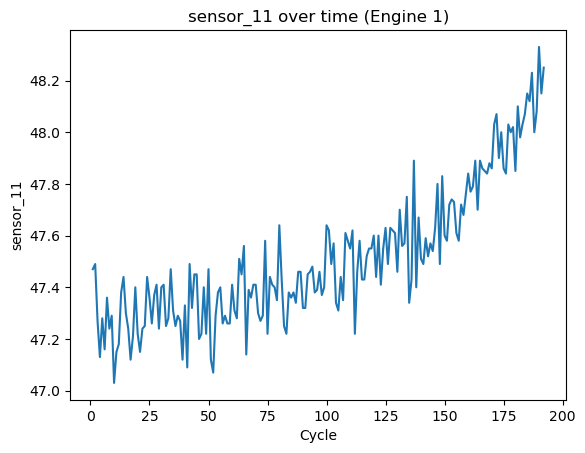

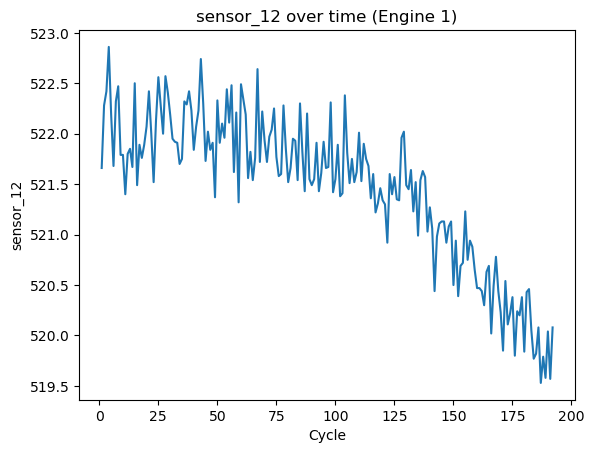

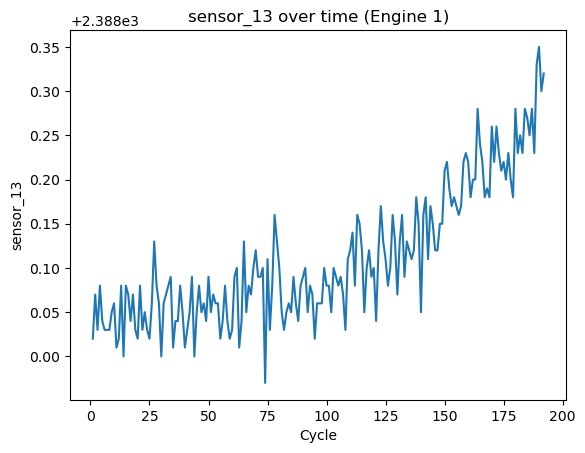

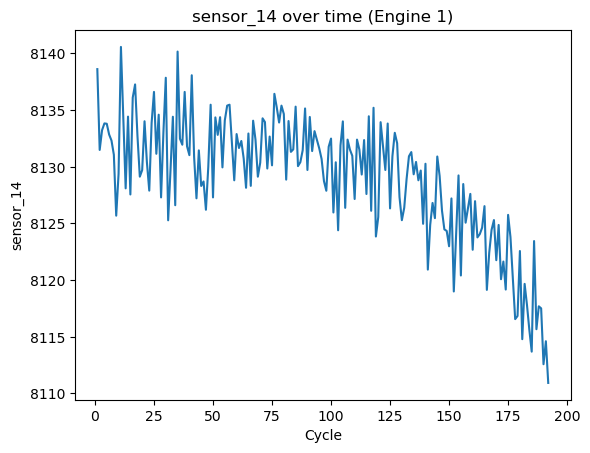

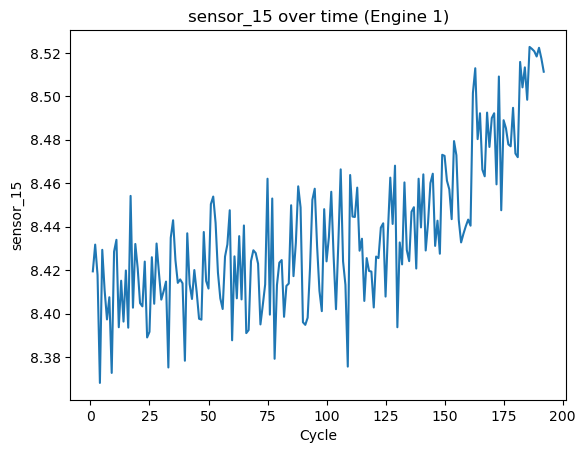

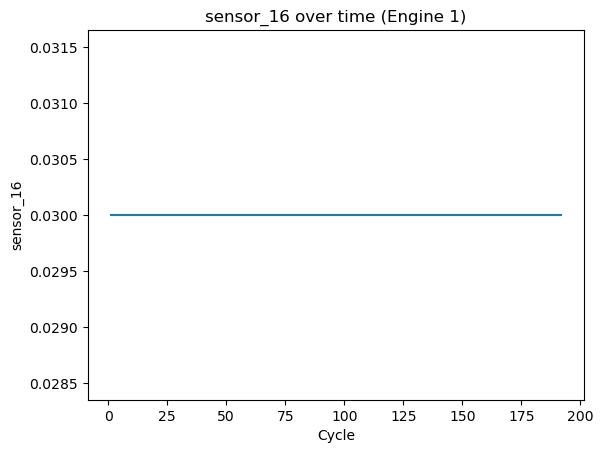

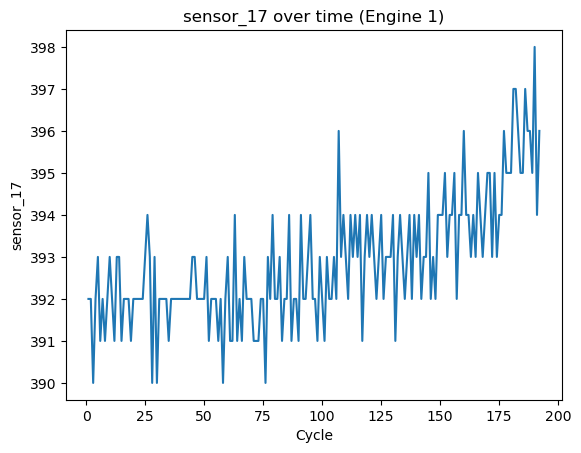

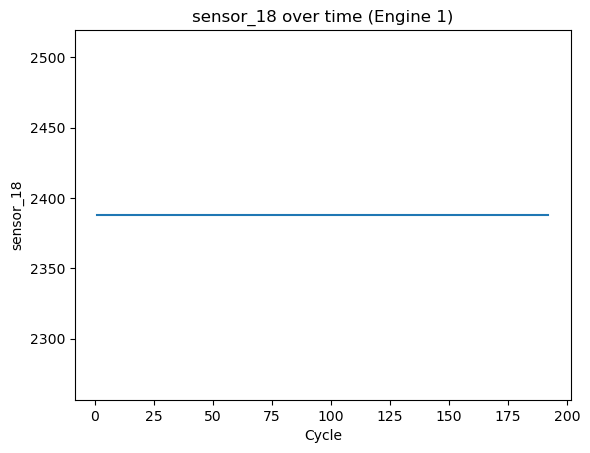

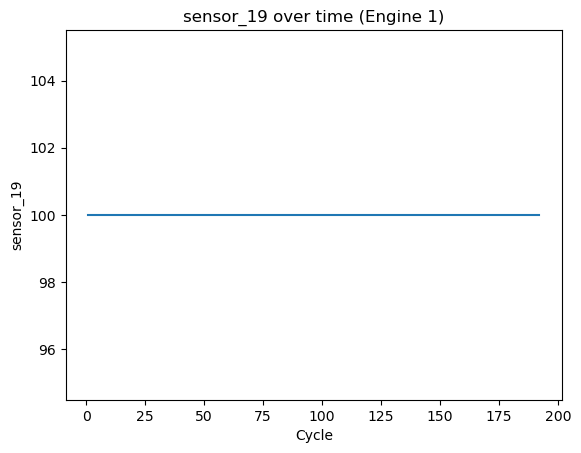

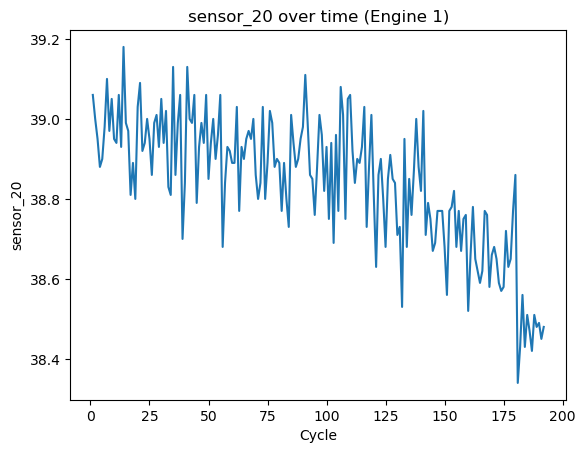

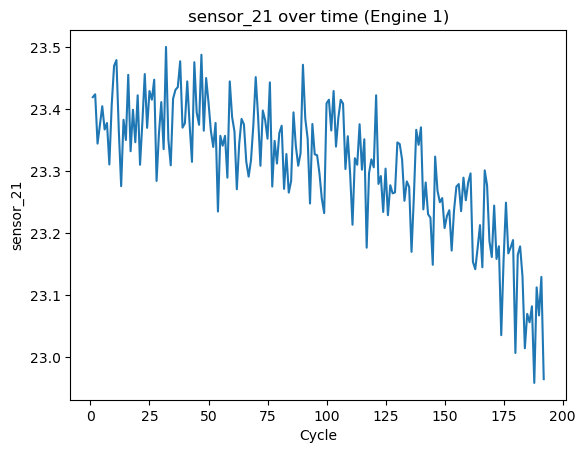

In [6]:
import matplotlib.pyplot as plt
eng_1 = df[df["engine_id"]==1]
sensors = [f"sensor_{i}" for i in range(1,22)]
for s in sensors:
    plt.figure()
    plt.plot(eng_1["cycle"], eng_1[s])
    plt.xlabel("Cycle")
    plt.ylabel(s)
    plt.title(f"{s} over time (Engine 1)")
    plt.show()




## Day-2: Feature Engineering


In [7]:
selected_sensors = [
    "sensor_7",
    "sensor_12",
    "sensor_14",
    "sensor_20",
    "sensor_21"
]

op_settings = [
    "op_setting_1",
    "op_setting_2",
    "op_setting_3"
    
]

feature_columns = selected_sensors + op_settings


In [8]:
X=df[feature_columns]

In [9]:
X.head()
X.shape

(20631, 8)

In [10]:
y=df["RUL"]
y.head()
y.shape

(20631,)

In [11]:
print("X shape:",X.shape)
print("Y shape:",y.shape)

X shape: (20631, 8)
Y shape: (20631,)


 ## x & y in ML
 x - denotes the conditions an engine undergoes at each cycle
y - denotes the RUL values for the corresponding conditions

TRAIN/TEST SPLIT

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

lr_model = LinearRegression()
lr_model.fit(X_train,y_train)


(18567, 8)
(2064, 8)
(18567,)
(2064,)


LinearRegression()

In [13]:
y_pred = lr_model.predict(X_test)
y_pred[:5]

array([113.30707349,  21.94834102, 157.01132642, -76.48983011,
       130.44017672])

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 35.112480890340116
RMSE: 45.22196668371675


XGBoost - for learning complex degradation behaviour

In [15]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [16]:
from xgboost import XGBRegressor

In [17]:
xgb_model =XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

In [18]:
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [19]:
y_pred_xgb = xgb_model.predict(X_test)

EVALUVATION OF XGBoost

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_xgb = mean_absolute_error(y_test,y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test,y_pred_xgb))

print("XGBoost MAE:",mae_xgb)
print("XGBoost RMSE:",rmse_xgb)

XGBoost MAE: 30.967365579087605
XGBoost RMSE: 42.50481737852425


Re-training XGBoost

In [21]:
from xgboost import XGBRegressor
final_xgb_model = XGBRegressor(
    x_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
final_xgb_model.fit(X_train,y_train)

c:\Users\HP\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:12:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "x_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [22]:
import joblib

In [27]:
joblib.dump(final_xgb_model, "../models/xgb_rul_model.pkl")
joblib.dump(feature_columns, "../models/feature_columns.pkl")


['../models/feature_columns.pkl']